In [7]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm  # for notebooks
# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

In [8]:
def choose_target_period(pat, mins_before_first_icp=60 * 24, target_name="ICP_Vital",
                         min_val=-10, max_val=105):
    target_steps = pat[pat["Maßnahme"] == target_name]
    no_outlier_mask = (target_steps["Wert"] >= min_val) & (target_steps["Wert"] <= max_val)
    target_steps = target_steps[no_outlier_mask]
    # kick out targets beyond thresholds
    if len(target_steps) == 0:
        return pat.iloc[0:0]
    #else:
    #    pat = pat[no_outlier_mask]
    min_target_time = min(target_steps["rel_time"])
    min_allowed_time = min_target_time - mins_before_first_icp
    max_target_time = max(target_steps["rel_time"])
    # kick out (basically set to NaN) measurements beyond interesting region
    pat = pat[pat["rel_time"] >= min_allowed_time]
    pat = pat[pat["rel_time"] <= max_target_time]
    # adjust rel_time
    pat["rel_time"] -= min(pat["rel_time"])
    return pat

In [3]:
load_icp = True

if load_icp:
    df_long = pd.read_csv("data/Datenbank_icp.csv")
    if "Unnamed: 0" in df_long:
        df_long = df_long.drop(columns=["Unnamed: 0"])
else:
    df_long = pd.read_csv("data/Datenbank_Werte.csv")
    print("Loaded data")
    # drop eICU
    df_long = df_long[df_long["DB"] != "eICU"]
    
    # add type to Maßnahme
    df_long["Maßnahme"] += "_" + df_long["ID"]
    df_long = df_long.drop(columns="ID")

    # drop measurements where we have a "NAN"
    print("Drop NaN measurements")
    df_long = df_long.dropna(subset=["Wert"])
    
    # drop duplicates
    print("Dropping duplicates...")
    df_long = df_long.drop_duplicates(subset=["Pat_ID", "Maßnahme", "rel_time", "Wert"])
    
    # fix rel_times to ICP, drop steps after last ICP measurement, filter ICP outliers
    # use 0.999 quantile = -10 to 105
    print("Fixing ICP times...")
    df_long = df_long.groupby("Pat_ID").apply(lambda pat: 
                                choose_target_period(pat, mins_before_first_icp=60 * 24, 
                                                     target_name="ICP_Vital",
                                                     min_val=-10, max_val=105))
    df_long = df_long.reset_index(drop=True)

    # merge "NBD" (non-invasive ways of measuring blood pressure) with invasive ways as they measure the same thing
    print("Merging NBD...")
    def rename_nbd(name):
        if "syst" in name:
            name = "syst_Vital"
        elif "diast" in name:
            name = "diast_Vital"
        elif "mittl" in name:
            name = "mittl_Vital"
        return name
    df_long["Maßnahme"] = df_long["Maßnahme"].apply(rename_nbd)
    
    df_long.to_csv("data/Datenbank_icp.csv", index=False)
print("Data loaded!")

/home/anton/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Data loaded!


In [4]:
df_long

,Pat_ID,Maßnahme,Maßnahme_norm,rel_time,Wert,DB
0,474096103,Erythrocyten_Labor,Erythrocyten,327.0,3.230000,UKE
1,474096103,MCH_Labor,MCH,327.0,30.200000,UKE
2,474096103,MCHC_Labor,MCHC,327.0,33.600000,UKE
3,474096103,MCV_Labor,MCV,327.0,89.800000,UKE
4,474096103,Thrombocyten_Labor,Thrombocyten,327.0,166.000000,UKE
...,...,...,...,...,...,...
81746132,99863_100749,Narkotikum_Med,Propofol,18056.0,20.224083,MIMIC
81746133,99863_100749,Narkotikum_Med,Propofol,18057.0,20.224083,MIMIC
81746134,99863_100749,Narkotikum_Med,Propofol,18058.0,20.224083,MIMIC
81746135,99863_100749,Narkotikum_Med,Propofol,18059.0,20.224083,MIMIC


In [5]:
# determine columns that have few missings - add min, max, std for those
val_counts = df_long.groupby("DB").apply(lambda db: db.groupby("Maßnahme").apply(lambda m: len(m))).reset_index(drop=False)
val_counts = val_counts.groupby("Maßnahme").mean()[0]
val_counts

Maßnahme
AF_Vital              323942.5
ALT_Labor               2571.5
AST_Labor               2496.0
Albumin_Labor           2104.0
Alk_Labor               1164.0
                        ...   
mittl_Vital           306330.0
pH_BGA                 65395.5
pankreasspez_Labor       958.5
sO2_BGA                58318.5
syst_Vital            306186.5
Name: 0, Length: 81, dtype: float64

In [6]:
# select high count vitals 
quant = 200000 # chosen such that ICP and everything more frequent than it stays in #np.quantile(val_counts, 0.85)
print(quant)
mask = (val_counts > quant).astype(int) + val_counts.index.str.contains("_Vital").astype(int) #+  (~val_counts.index.str.contains("ICP")).astype(int)
mask = mask == 2
high_counts = val_counts[mask].sort_values(0)
print(high_counts)
high_counts = list(high_counts.index) + ["ICP_Vital"]

200000
Maßnahme
CPP_Vital      256991.5
ICP_Vital      278880.0
SpO2_Vital     287741.5
HF_Vital       293872.5
diast_Vital    304844.0
syst_Vital     306186.5
mittl_Vital    306330.0
AF_Vital       323942.5
Name: 0, dtype: float64


/tmp/ipykernel_18879/3627366531.py:6: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only
  high_counts = val_counts[mask].sort_values(0)


In [59]:
minutes = 120

In [60]:
df_long_mimic = df_long[df_long["DB"] == "UKE"]

In [ ]:
df_long_mimic_icp = df_long_mimic[df_long_mimic["Maßnahme"] == "ICP_Vital"]

In [ ]:
df_long_mimic_icp["rel_time"].diff()

112          NaN
113         37.0
114         49.0
115         55.0
116         34.0
            ... 
68418073    30.0
68418074    30.0
68418075    30.0
68418076    30.0
68418077    30.0
Name: rel_time, Length: 368185, dtype: float64

In [ ]:
df_long_mimic_icp

,Pat_ID,Maßnahme,Maßnahme_norm,rel_time,Wert,DB
112,474096103,ICP_Vital,ICP,27.0,-6.0,UKE
113,474096103,ICP_Vital,ICP,64.0,-8.0,UKE
114,474096103,ICP_Vital,ICP,113.0,-9.0,UKE
115,474096103,ICP_Vital,ICP,168.0,-8.0,UKE
116,474096103,ICP_Vital,ICP,202.0,-8.0,UKE
...,...,...,...,...,...,...
68418073,597077779,ICP_Vital,ICP,1200.0,50.0,UKE
68418074,597077779,ICP_Vital,ICP,1230.0,51.0,UKE
68418075,597077779,ICP_Vital,ICP,1260.0,51.0,UKE
68418076,597077779,ICP_Vital,ICP,1290.0,51.0,UKE


In [ ]:
diffs = df_long_mimic_icp.groupby("Pat_ID").apply(lambda pat: pat.sort_values("rel_time")["rel_time"].diff())

In [ ]:
diffs[diffs > 10000]

Pat_ID             
495108527  7277299     11453.0
504991188  14762089    16827.0
514963989  21520743    11061.0
535380365  40638454    22265.0
544413324  46294150    14732.0
564047304  54549908    11787.0
573864154  58462693    10728.0
583330420  62263657    17928.0
586712988  65694752    16142.0
Name: rel_time, dtype: float64

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
diffs.describe()

count    367005.000000
mean         45.683726
std          88.080010
min           0.000000
25%          28.000000
50%          39.000000
75%          60.000000
max       22265.000000
Name: rel_time, dtype: float64

Text(0.5, 1.0, 'Histogram of time between ICP measurements for UKE')

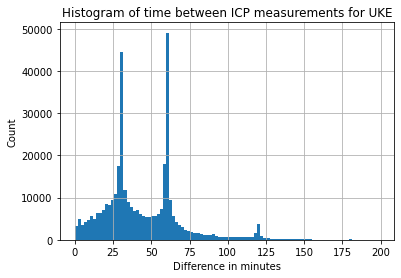

In [ ]:
diffs[diffs < 200].hist(bins=100)
plt.xlabel("Difference in minutes")
plt.ylabel("Count")
plt.title("Histogram of time between ICP measurements for UKE")

In [ ]:
from typing import Tuple, List

import importlib
import numba


@numba.jit()
def create_dict(values: np.ndarray, rel_time: np.ndarray, measure_name: str, high_counts: Tuple[str]):
    means = []
    stds = []
    mins = []
    maxs = []
    rel_times = []
    i = 0
    while i < len(values): 
        # add consequent measurements as long as they fit in time window
        # subtract remainder to make sure rel_times are fitted in the right time window
        current_rel_time = rel_time[i] - (rel_time[i] % minutes)  
        vals = []
        while i < len(values) and rel_time[i] < current_rel_time + minutes:
            vals.append(values[i])
            i += 1
        # summarize values
        vals = np.array(vals)
        means.append(np.mean(vals))
        rel_times.append(current_rel_time)
        # add detailed summary if it is a high count feature
        if measure_name in high_counts:
            stds.append(np.std(vals))
            mins.append(np.min(vals))
            maxs.append(np.max(vals))
    return means, stds, mins, maxs, rel_times


def summarize_measure(measure, high_counts, minutes):
    # get name and relevant columns
    measure_name = measure["Maßnahme"].iloc[0]
    rel_time = measure["rel_time"].to_numpy().astype(float)
    values = measure["Wert"].to_numpy().astype(float)
    # get lists
    means, stds, mins, maxs, rel_time = create_dict(values, rel_time, measure_name, high_counts)
    # create new, shorter df with same base stats (Pat_ID etc.)
    new_df = pd.DataFrame({"rel_time": rel_time, "Wert": means})
    new_df["Pat_ID"] = measure["Pat_ID"].iloc[0]
    new_df["Maßnahme"] = measure["Maßnahme"].iloc[0]
    new_df["Maßnahme_norm"] = measure["Maßnahme_norm"].iloc[0]
    new_df["DB"] = measure["DB"].iloc[0]
    if len(stds) > 0:
        # if we have additional stats for this feature, copy the df above, fill in other value and append it
        new_measures = {measure_name: means,
                        measure_name + "_std": stds,
                        measure_name + "_min": mins,
                        measure_name + "_max": maxs} 
        dfs = [new_df.copy() for key in new_measures]
        for df, key in zip(dfs, new_measures):
            df["Maßnahme"] = key
            df["Wert"] = new_measures[key]
        new_df = pd.concat(dfs, axis=0)
    return new_df
            

def summarize_patient(pat, minutes):
    # assumes a patient, sorted by rel_time, with 1 minute steps
    return pat.groupby("Maßnahme").apply(lambda measure: summarize_measure(measure, high_counts, minutes)).reset_index(drop=True)

df_long_summarized = df_long.groupby("Pat_ID").progress_apply(lambda pat: summarize_patient(pat.sort_values("rel_time", ascending=True), minutes)).reset_index(drop=True)
# summarize per N minutes (5 min, 60 min) 
# take mean, min, max, std per Vital measure

  0%|          | 0/2137 [00:00<?, ?it/s]

/home/anton/.local/lib/python3.8/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'high_counts' of function 'create_dict'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../tmp/ipykernel_18879/4280604744.py", line 7:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/home/anton/.local/lib/python3.8/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'lst' of function 'in_seq.<locals>.seq_contains_impl'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../.local/

In [ ]:
# norm med by maßnahme norm per db
meds = [feat for feat in df_long_summarized["Maßnahme"].unique() if "_Med" in feat]
def norm_group(group):
    if group["Maßnahme"].iloc[0] in meds:
        group["Wert"] = (group["Wert"] - group["Wert"].mean()) / group["Wert"].std()
    return group
df_long_normed_med = df_long_summarized.groupby("DB").apply(lambda db: db.groupby("Maßnahme_norm").apply(norm_group)).reset_index(drop=True)
#df_long = df_long.drop(columns=["Maßnahme_norm"])

In [ ]:
icp_long = df_long[df_long["Maßnahme"] == "ICP_Vital"]
print(icp_long.groupby("DB").apply(len))
icp_long_summ = df_long_summarized[df_long_summarized["Maßnahme"] == "ICP_Vital"]
print(icp_long_summ.groupby("DB").apply(lambda x: len(x)))
icp_long_med_normed = df_long_normed_med[df_long_normed_med["Maßnahme"] == "ICP_Vital"]
print(icp_long_med_normed.groupby("DB").apply(lambda x: len(x)))

DB
MIMIC    189575
UKE      368185
dtype: int64
DB
MIMIC    150228
UKE      350787
dtype: int64
DB
MIMIC    150228
UKE      350787
dtype: int64


In [ ]:
# from long to wide
df = df_long_normed_med.pivot_table(index=["rel_time", "Pat_ID", "DB"], columns="Maßnahme", values="Wert").reset_index()

In [ ]:
print(len(df))
print(df.groupby("DB").apply(lambda x: len(x[~x["ICP_Vital"].isna()])))
print(df["ICP_Vital"].isna().mean())

1623019
DB
MIMIC    150228
UKE      350787
dtype: int64
0.6913067561131447


In [ ]:
df.to_csv(f"data/df_wide_{minutes}.csv", index=False)

In [ ]:
# Num ICP measurements per DB
df.groupby("DB").apply(lambda db: (~db["ICP_Vital"].isna()).sum())

DB
MIMIC    150228
UKE      350787
dtype: int64

In [ ]:
# fill in rows with NAN where we have no measurement at all

#@numba.jit()
def add_nan_rows(arr: np.ndarray, rel_time: np.ndarray, minutes: int):
    # check dist between all consecutive rel_times and create NaN array, which is added to list. Merge this list in the end
    num_feats = arr.shape[1]
    rows = []
    old_time = rel_time[0]
    for row, t in zip(arr, rel_time):
        #print(t)
        # check how many rows between old_time and current time have to be added
        num_rows = int(np.ceil((t - old_time) / minutes)) - 1
        if num_rows > 0:
            #print(num_rows)
            #num_rows_added.append(num_rows)
            new_rows = np.ones((num_rows, num_feats)) * np.nan
            rows.append(new_rows)
        rows.append(np.expand_dims(row, 0))
        old_time = t
    return np.concatenate(rows, axis=0)

num_rows_added = []
def unroll_patient(pat, minutes):
    # assumes a patient, sorted by rel_time
    # transform to numpy array and move to helper function
    rel_time = pat["rel_time"].to_numpy()
    db = pat["DB"].iloc[0]
    pat_id = pat["Pat_ID"].iloc[0]
    # drop DB and pat_id temporarily, as their type is str
    pat = pat.drop(columns=["DB", "Pat_ID"]).astype(np.float32)
    arr = pat.to_numpy()

    # get new_array that contains nan_rows where necessary
    #print("old array shape: ", pat.shape)
    new_array = add_nan_rows(arr, rel_time, minutes)
    num_rows_added.append(len(new_array) - len(arr))
    #print("new array shape: ", new_array.shape)
    # set Pat_ID, rel_time and col names correctly at end
    new_pat = pd.DataFrame(data=new_array, columns=pat.columns, index=np.arange(len(new_array)))
    new_pat["DB"] = db 
    new_pat["Pat_ID"] = pat_id
    # fill in rel_times
    start_time = pat["rel_time"].iloc[0]
    new_pat["rel_time"] = np.arange(start_time, start_time + len(new_pat) * minutes, minutes)
    return new_pat
    

df_filled = df.groupby("Pat_ID").progress_apply(lambda pat: unroll_patient(pat.sort_values("rel_time", ascending=True), minutes)).reset_index(drop=True)

  0%|          | 0/2137 [00:00<?, ?it/s]

In [ ]:
df.shape

(1623019, 108)

In [ ]:
df_filled.shape

(1803122, 108)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
np.sum(num_rows_added)

180103

In [ ]:
np.mean(num_rows_added)

84.27842770238652

Text(0.5, 0, 'Num consecutive missing steps')

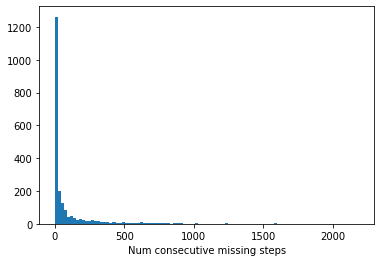

In [ ]:
p = plt.hist(num_rows_added, bins=100)
plt.xlabel("Num consecutive missing steps")

In [ ]:
len(num_rows_added)

2137

In [ ]:
df_filled.to_csv(f"data/df_filled_{minutes}.csv", index=False)

In [ ]:
#df_filled = pd.read_csv("data/df_filled_60.csv")

In [ ]:
df_filled

Maßnahme,rel_time,AF_Vital,AF_Vital_max,AF_Vital_min,AF_Vital_std,ALT_Labor,AST_Labor,Albumin_Labor,Alk_Labor,Alpha Blocker_Med,...,mittl_Vital_std,pH_BGA,pankreasspez_Labor,sO2_BGA,syst_Vital,syst_Vital_max,syst_Vital_min,syst_Vital_std,DB,Pat_ID
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UKE,474096103
1,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,130.0,130.0,130.0,0.0,UKE,474096103
2,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UKE,474096103
3,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UKE,474096103
4,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,138.0,138.0,138.0,0.0,UKE,474096103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1803117,18000.0,23.0,23.0,23.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,166.0,166.0,166.0,0.0,MIMIC,99863_100749
1803118,18015.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MIMIC,99863_100749
1803119,18030.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MIMIC,99863_100749
1803120,18045.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MIMIC,99863_100749


In [ ]:
# fill med missing with 0
df_med_filled = df_filled.copy()
med_col_names = [col for col in df_med_filled.columns if "_Med" in col]
df_med_filled[med_col_names] = df_med_filled[med_col_names].fillna(df_med_filled[med_col_names].min())

In [ ]:
# disabled for now as it reduces UKE performance a lot. Might be useful for better dataset transfer in the future
"""
# show values with highest std of NaNs between DBs
max_nan_frac_over_dbs = df_med_filled.groupby("DB").apply(lambda db: db.isna().mean()).std().sort_values().iloc[-10:]
max_nan_frac_over_dbs
# select highest ranking ones
drop_cols = ["PEEP_Vital", "Pmean_Vital", "Freq gesamt_Vital", "Ppeak_Vital", "FiO2_Vital", "Freq spontan_Vital"]
"""
pass

In [ ]:
# select measurements with at least 99.9% missingness
max_missing = df_med_filled.groupby("DB").apply(lambda db: db.isna().mean()).max()
max_drop = max_missing[max_missing > 0.9999]
drop_cols = list(max_drop.index)

In [ ]:
drop_cols

['Bili_BGA',
 'CRP_Labor',
 'Cholesterin_Labor',
 'FiO2_BGA',
 'fT3_Labor',
 'fT4_Labor']

In [ ]:
# remove feature that have N% missing spots in at least one database
#threshold = 1 - (1 - 0.999) / (60 / minutes)  # make it such that it is 0.99 for 60 minutes and 0.999 for 5 minutes
#max_nan_frac_over_dbs = df_med_filled.groupby("DB").apply(lambda db: db.isna().mean()).max().sort_values()
#drop_cols = list(max_nan_frac_over_dbs[max_nan_frac_over_dbs > threshold].index)
df_drop_too_missing = df_med_filled.drop(columns=drop_cols)
print("Dropped: ", drop_cols, " - ", len(drop_cols))

Dropped:  ['Bili_BGA', 'CRP_Labor', 'Cholesterin_Labor', 'FiO2_BGA', 'fT3_Labor', 'fT4_Labor']  -  6


In [ ]:
# get patient data such as gender etc
df_static = pd.read_csv("data/Datenbank_Pat_ID.csv")
df_static = df_static[["Pat_ID", "Alter", "Diagnose_txt", "Geschlecht", "Größe", "Gewicht"]]
df_static = df_static.rename(columns={"Diagnose_txt": "Diagnose"})
# one-hot encode
df_static = pd.get_dummies(df_static, columns=["Diagnose", "Geschlecht"])
df_static = df_static.drop(columns=["Geschlecht_Weiblich"])
df_static = df_static.rename(columns={"Geschlecht_Männlich": "Geschlecht"})
# drop nan Pat_ID
df_static = df_static.dropna(subset=["Pat_ID"])

In [ ]:
# merge
df_drop_too_missing["Pat_ID"] = df_drop_too_missing["Pat_ID"].astype(int)
df_static["Pat_ID"] = df_static["Pat_ID"].astype(int)
df_large = pd.merge(df_drop_too_missing, df_static, on="Pat_ID", how="left")

In [ ]:
# one-hot-encode DB
df_large = pd.get_dummies(df_large, columns=["DB"])

In [ ]:
path = f"data/df_final_{minutes}.csv"
df_large.to_csv(path, index=False)
print("Saved to: ", path)

Saved to:  data/df_final_15.csv


In [ ]:
#df_large.isna().mean().sort_values().iloc[-30:]

In [ ]:
# remove correlated feats
threshold = 0.95
dataset = df_large.drop(columns=["ICP_Vital"])
targets = df_large["ICP_Vital"]

# remove target from this correlation table as we want to keep features that are highly correlated with the target
print("Cols before corr:", len(dataset.columns))
col_corr = set() # Set of all the names of deleted columns
corr_matrix = dataset.corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if (abs(corr_matrix.iloc[i, j]) >= threshold) and (corr_matrix.columns[j] not in col_corr):
            colname = corr_matrix.columns[i] # getting the name of column
            if "DB_" in colname: 
                continue
            col_corr.add(colname)
            if colname in dataset.columns:
                print("Deleting column with name, ", colname, " as it is too highly correlated (", corr_matrix.iloc[i, j], ") with ", corr_matrix.columns[j])
                del dataset[colname] # deleting the column from the dataset                
print("Cols after corr:", len(dataset.columns))
# check correlations with Vital_ICP value
dataset["ICP"] = list(targets)
corr_matrix = dataset.corr()
icp_cor = corr_matrix["ICP"].to_numpy()
thresh = 0.0001
too_small_corr_mask = np.abs(icp_cor) < thresh
drop_cols = ["ICP"] + list(np.array(corr_matrix.columns)[too_small_corr_mask])
drop_cols = [c for c in drop_cols if "DB_" not in c]
print("Dropping because of too small correlation with target: ", drop_cols)
dataset = dataset.drop(columns=drop_cols)   

df_decorrelated = pd.concat([dataset, targets], axis=1)

Cols before corr: 112
Deleting column with name,  AF_Vital_max  as it is too highly correlated ( 0.9921775724452703 ) with  AF_Vital
Deleting column with name,  AF_Vital_min  as it is too highly correlated ( 0.9924611913040874 ) with  AF_Vital
Deleting column with name,  CPP_Vital_max  as it is too highly correlated ( 0.994101917236743 ) with  CPP_Vital
Deleting column with name,  CPP_Vital_min  as it is too highly correlated ( 0.9948471656472168 ) with  CPP_Vital
Deleting column with name,  HF_Vital_max  as it is too highly correlated ( 0.9987031626644765 ) with  HF_Vital
Deleting column with name,  HF_Vital_min  as it is too highly correlated ( 0.998694449506421 ) with  HF_Vital
Deleting column with name,  Hk_Labor  as it is too highly correlated ( 0.9587890013844723 ) with  Hb_BGA_BGA
Deleting column with name,  ICP_Vital_min  as it is too highly correlated ( 0.9814265576293585 ) with  ICP_Vital_max
Deleting column with name,  SBE_BGA  as it is too highly correlated ( 0.987342623859

In [ ]:
df_large.shape

(1803122, 113)

In [ ]:
df_decorrelated.shape

(1803122, 97)

In [ ]:
db_cols = [col for col in df_decorrelated.columns if "DB_" in col]
db_cols

['DB_MIMIC', 'DB_UKE']

In [ ]:
def add_split_idcs(df, test_size=0.1):
    pat_ids = df["Pat_ID"].unique()
    seq_list = [df[df["Pat_ID"] == pat_id] for pat_id in pat_ids]
    dev_data, test_data, dev_idcs, test_idcs = make_split(seq_list, test_size=0.1)
    #df[dev_idcs]["split"] = "dev"
    #df.loc[test_idcs, "split"] = "test"
    train_data, val_data, train_idcs, val_idcs = make_split(dev_data, test_size=0.1)
    mapped_train_idcs = dev_idcs[train_idcs]
    mapped_val_idcs = dev_idcs[val_idcs]
    
    # map idcs to pat_ids
    train_pat_ids = set(pat_ids[mapped_train_idcs])
    val_pat_ids = set(pat_ids[mapped_val_idcs])
    test_pat_ids = set(pat_ids[test_idcs])
    
    # set column in original df according to idcs
    def assign_split_name(pat_id):
        if pat_id in train_pat_ids:
            return "train"
        elif pat_id in val_pat_ids:
            return "val"
        else:
            return "test"
    df["split"] = df["Pat_ID"].apply(assign_split_name)
    
    return df

In [ ]:
import os

from data_utils import make_split

for db_name in db_cols:
    print(db_name)
    db_df = df_decorrelated[df_decorrelated[db_name] == 1].drop(columns=db_cols)
    # make splits
    db_df = add_split_idcs(db_df, test_size=0.1)
    # save it
    save_path = f"data/{db_name}_{minutes}_final_df.pkl"
    os.makedirs("data/", exist_ok=True)
    db_df.to_pickle(save_path)

DB_MIMIC
DB_UKE


In [ ]:
save_path

'data/DB_UKE_15_final_df.pkl'

In [ ]:
(db_df["split"] == "train").sum()

948192

In [ ]:
list(db_df.columns)

['rel_time',
 'AF_Vital',
 'AF_Vital_std',
 'ALT_Labor',
 'AST_Labor',
 'Albumin_Labor',
 'Alk_Labor',
 'Alpha Blocker_Med',
 'Barbiturat_Med',
 'Basophile_Labor',
 'Benzodiazepin_Med',
 'CK-MB_Labor',
 'CK_Labor',
 'CPP_Vital',
 'CPP_Vital_std',
 'Ca_BGA',
 'Cl_BGA',
 'Direkter Vasodilatator_Med',
 'EVB_Labor',
 'Eosinophile_Labor',
 'Erythrocyten_Labor',
 'FCOHb_BGA',
 'FiO2_Vital',
 'Freq gesamt_Vital',
 'Freq spontan_Vital',
 'GCS_auge_Vital',
 'GCS_motor_Vital',
 'GCS_total_Vital',
 'GCS_verbal_Vital',
 'Glu_BGA',
 'HCO3_BGA',
 'HF_Vital',
 'HF_Vital_std',
 'Harnstoff-N_Labor',
 'Hb_BGA_BGA',
 'ICP_Vital_max',
 'ICP_Vital_std',
 'INR_Labor',
 'K_BGA',
 'Katecholamin_Med',
 'Kreatinin_Labor',
 'LDH_Labor',
 'Lac_BGA',
 'Leukocyten_Labor',
 'Lipase_Labor',
 'Lymphocyten_Labor',
 'MCHC_Labor',
 'MCH_Labor',
 'MCV_Labor',
 'Magnesium_Labor',
 'Monocyten_Labor',
 'Na_BGA',
 'Narkotikum_Med',
 'Neutrophile_Labor',
 'Opioid_Med',
 'PCO2_BGA',
 'PEEP_Vital',
 'PO2_BGA',
 'Phosphat_Labor',

<AxesSubplot:>

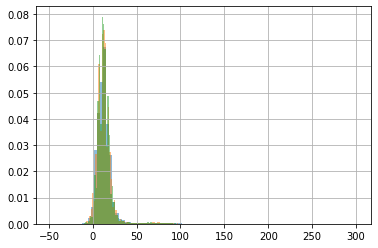

In [ ]:
# check icp distributions
db_df[db_df["split"] == "train"]["ICP_Vital"].hist(bins=100, density=True, alpha=0.5)
db_df[db_df["split"] == "val"]["ICP_Vital"].hist(bins=100, density=True, alpha=0.5)
db_df[db_df["split"] == "test"]["ICP_Vital"].hist(bins=100, density=True, alpha=0.5)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# check distributions
p = uke_df.hist(bins=100, figsize=(15, 15))
plt.tight_layout()

NameError: name 'uke_df' is not defined

In [ ]:
from sklearn.preprocessing import PowerTransformer

transform = PowerTransformer(method='yeo-johnson', standardize=True)

In [ ]:
uke_df = df_large[df_large["DB_UKE"] == 1]

In [ ]:
uke_arr = uke_df.to_numpy()

In [ ]:
transform.fit(uke_arr)

In [ ]:
np.round(transform.lambdas_, 1)

In [ ]:
transformed_arr = transform.transform(uke_arr)

In [ ]:
lambdas_ = transform.lambdas_
mask = np.abs(lambdas_) > 5
print(lambdas_[mask])

In [ ]:
transformed_df = pd.DataFrame(transformed_arr, columns=df_large.columns)#, index=df_large.index)

In [ ]:
feat = "sO2_BGA"

In [ ]:
idx = list(transformed_df.columns).index(feat)
lambdas_[idx]

In [ ]:
uke_df[feat].describe()

In [ ]:
transformed_df[feat].describe()

In [ ]:
uke_df[feat].unique()

In [ ]:
transformed_df[feat].unique()

In [ ]:
uke_df[feat].hist(bins=100)

In [ ]:
transformed_df[feat].hist(bins=100)

In [ ]:
import numba
import numpy as np

@numba.jit()
def ema_fill(pat: np.ndarray, ema_val: float, mean: np.ndarray):
    # init ema
    ema = np.ones_like(pat[0]) * pat[0]
    ema[np.isnan(ema)] = mean[np.isnan(ema)]
    # run ema
    ema_steps = np.ones_like(pat)
    for i, pat_step in enumerate(pat):
        pat_step[np.isnan(pat_step)] = 0
        ema = ema_val * ema + (1 - ema_val) * pat_step
        ema_steps[i] = ema.copy()
    return ema_steps

In [ ]:
mean = uke_df.mean().to_numpy()

In [ ]:
uke_filled = uke_df.groupby("Pat_ID").apply(lambda pat: pd.DataFrame(ema_fill(pat.sort_values("rel_time").to_numpy(), 0.9, mean), columns=pat.columns))

In [ ]:
def four_parts(df):
    leng = len(df)
    first = df.iloc[0: leng // 4].mean()
    second = df.iloc[leng // 4: leng // 2].mean()
    third = df.iloc[leng // 2: leng * 3 // 4].mean()
    fourth = df.iloc[leng * 3 // 4:].mean()
    all_parts = [first, second, third, fourth]
    return pd.DataFrame(all_parts, columns=df.columns)

In [ ]:
umap_arr_red = umap_norm.reset_index(drop=True).groupby("Pat_ID").apply(four_parts).reset_index(drop=True).dropna()

In [ ]:
umap_arr_dropped = umap_arr_red.drop(columns=["DB_MIMIC", "DB_UKE", "DB_eICU", "Pat_ID", "ICP_Vital"]).to_numpy()

In [ ]:
from sklearn.preprocessing import PowerTransformer

def apply_yeo(df, thresh=50, lambs=None):
    transform = PowerTransformer(method='yeo-johnson', standardize=False)
    drop_cols = ["DB_MIMIC", "DB_UKE", "DB_eICU", "Pat_ID", "ICP_Vital", "rel_time"]
    dropped = df.drop(columns=drop_cols)
    arr = dropped.to_numpy()
    if lambs is None:
        # apply yeo
        transform.fit(arr)
        lambs = transform.lambdas_ 
        mask = np.abs(lambs) > thresh
        print(df["DB_MIMIC"].sum(), df["DB_UKE"].sum(), df["DB_eICU"].sum())
        print(mask.sum())
        #print(pd.Series(np.round(lambs, 1), index=dropped.columns).sort_values(np.abs(lambs)))
        print(np.round(lambs, 1))
        print()
        lambs[mask] = 1
    transform.lambdas_ = lambs
    trans_arr = transform.transform(arr)
    # merge back
    df = pd.concat([pd.DataFrame(trans_arr, columns=dropped.columns), df[drop_cols]], axis=1)
    return df, lambs

In [ ]:
def create_umap_df(df, yeo=False, lambs=None, mean=None, std=None, thresh=10):
    # apply yeo
    if yeo:
        df, _ = apply_yeo(df, lambs=lambs, thresh=thresh)
    # calc median
    median = df.median().to_numpy()
    # fill using ema
    df_filled = df.groupby("Pat_ID").apply(lambda pat: pd.DataFrame(ema_fill(pat.sort_values("rel_time").to_numpy(), 0.9, median), columns=pat.columns)).reset_index(drop=True)
    # calc mean
    if mean is None:
        mean = df_filled.mean()
        std = df_filled.std()
        mean[std == 0] = 0
        std[std == 0] = 1
    #norm
    df_norm = (df_filled - mean) / std
    # average over four regions per Pat
    df_red = df_norm.groupby("Pat_ID").apply(four_parts).reset_index(drop=True).dropna()
    return df_red

In [ ]:
yeo = False
use_train_stats = False
thresh = 10

lambs = None
mean = None
std = None
    
if use_train_stats:
    train_df = df_large[df_large["DB_UKE"] == 1]
    if yeo:
        # calc lambdas for train dataset
        #train_df_filled = train_df.groupby("Pat_ID").apply(lambda pat: pd.DataFrame(ema_fill(pat.astype(float).sort_values("rel_time").to_numpy(), 0.9, train_df.median()), columns=pat.columns)).reset_index(drop=True)
        train_df, lambs = apply_yeo(train_df, thresh=thresh)
         # calc median
        median = train_df.median().to_numpy()
        # fill using ema
        train_df = train_df.groupby("Pat_ID").apply(lambda pat: pd.DataFrame(ema_fill(pat.sort_values("rel_time").to_numpy(), 0.9, median), columns=pat.columns)).reset_index(drop=True)
    
    # calc mean
    mean = train_df.mean().to_numpy()
    std = train_df.std()
    mean[std == 0] = 0
    std[std == 0] = 1


grouper = df_large["DB_UKE"] * 1 + df_large["DB_MIMIC"] * 2 + df_large["DB_eICU"] * 3
df_red = df_large.groupby(grouper).apply(lambda db: create_umap_df(db, yeo=yeo, lambs=lambs, mean=mean, std=std, thresh=thresh))
#df_red = transformed_df.groupby(grouper).apply(create_umap_df)

In [ ]:
if std is not None:
    std.sort_values()

In [ ]:
db_values = df_red["DB_UKE"] * 1 + df_red["DB_MIMIC"] * 2 + df_red["DB_eICU"] * 3
db_values[db_values == 1] = "UKE"
db_values[db_values == 2] = "MIMIC"
db_values[db_values == 3] = "eICU"

In [ ]:
# drop some cols and to numpy
drop_cols = ["DB_MIMIC", "DB_UKE", "DB_eICU", "Pat_ID", "ICP_Vital"]
#drop_cols.extend([col for col in df_red.columns if "_Med" in col])
#drop_cols.extend([col for col in df_red.columns if "Diagnose" in col])
#drop_cols.extend([col for col in df_red.columns if "BGA" in col])
#drop_cols.extend([col for col in df_red.columns if "Labor" in col])
#drop_cols.extend([col for col in df_red.columns if "Vital" in col])

#print(drop_cols)
dropped = df_red.drop(columns=drop_cols)
#print(dropped.columns)
arr = dropped.to_numpy()

In [ ]:
df_used.groupby(grouper).apply(lambda db: db["Cl_BGA"].mean())

In [ ]:
df_used.groupby(grouper).apply(lambda db: db["Cl_BGA"].std())

In [ ]:
dropped.groupby(db_values).apply(lambda db: db["Cl_BGA"].std())

In [ ]:
dropped.groupby(db_values).apply(lambda db: db["Cl_BGA"].mean())

In [ ]:
dropped["Cl_BGA"].std()

In [ ]:
from umap import UMAP
import umap.plot

umapper = UMAP(n_components=2, n_neighbors=15)
umapped_arr = umapper.fit_transform(arr)

In [ ]:
from sklearn.decomposition import PCA
mapper = PCA()

pca_arr = mapper.fit_transform(arr)
pca_arr.shape

In [ ]:
colors = db_values.copy()
colors[colors=="UKE"] = "red"
colors[colors=="MIMIC"] = "blue"
colors[colors=="eICU"] = "green"

colors = df_red["DB_UKE"]
plt.figure(figsize=(15, 7))
plt.scatter(pca_arr[:, 0], pca_arr[:, 1], c=colors, s=1.5)

In [ ]:
plt.plot(mapper.explained_variance_)

In [ ]:
comp_idx = 0
plt.bar(range(len(mapper.components_[comp_idx])), mapper.components_[comp_idx])
print(mapper.components_[comp_idx].sum())

In [ ]:
max_comp_idx = np.argmax(mapper.components_[comp_idx])
print(max_comp_idx)
print(dropped.columns[max_comp_idx])

In [ ]:
dropped.groupby(db_values).apply(lambda x: x["Temp_Vital"].std())

In [ ]:
#help(UMAP)

In [ ]:
#umap.plot.points(umapper, theme="fire", values=df_red["Pupille re_Vital"])

In [ ]:
umap.plot.points(umapper, theme="fire", values=df_red["Phosphat_Labor"])

In [ ]:
# yeo all
umap.plot.points(umapper, theme="fire", labels=db_values)

In [ ]:
umap.plot.points(umapper, theme="fire", labels=db_values)

In [ ]:
# yeo all
umap.plot.points(umapper, theme="fire", labels=db_values)

In [ ]:
# all
umap.plot.points(umapper, theme="fire", labels=db_values)

In [ ]:
# all yeo
umap.plot.points(umapper, theme="fire", labels=db_values)

In [ ]:
# only static
umap.plot.points(umapper, theme="fire", labels=db_values)

In [ ]:
# only vital
umap.plot.points(umapper, theme="fire", labels=db_values)

In [ ]:
# no med + no diag
umap.plot.points(umapper, theme="fire", labels=db_values)

In [ ]:
# no med
umap.plot.points(umapper, theme="fire", labels=db_values)

In [ ]:
umap.plot.points(umapper, theme="fire", labels=db_values)

In [ ]:
list(transformed_df.columns).index("Na_BGA")

In [ ]:
p = transformed_df.loc[:, mask].hist(figsize=(13, 13), bins=100)

In [ ]:
# find stds of 0
transformed_df.loc[:, transformed_df.std() == 0]

In [ ]:
transformed_df["sO2_BGA"].describe()

In [ ]:
np.quantile(transformed_df["sO2_BGA"].dropna(), 0.9999)

In [ ]:
np.quantile(df_large["sO2_BGA"].dropna(), 0.99)

In [ ]:
df_large["sO2_BGA"].describe()

In [ ]:
transformed_df.max()[transformed_df.max() > 5]

In [ ]:
transformed_df.loc[:, mask]

In [ ]:
transformed_df["Na_BGA"].hist(bins=100)
transformed_df["Na_BGA"].describe()

In [ ]:
p = transformed_df.hist(bins=100, figsize=(15, 15))
plt.tight_layout()

In [ ]:
(~df_large["ICP_Vital"].isna()).sum()

In [ ]:
(~df_large["ICP_Vital"].isna()).sum()

In [ ]:
len(df_large)

In [ ]:
(~df_large[df_large["DB_MIMIC"] == 1]["ICP_Vital"].isna()).sum()

In [ ]:
len(df_large[df_large["DB_MIMIC"] == 1]["ICP_Vital"])

In [ ]:
# 5 min: 3093093 ICP_Vital non_nans. 154014 in MIMIC
# len total: xxx. MIMIC: 2118712

In [ ]:
# 60 min: 585353 ICP VItal non_nans in total. 128303 in MIMIC
# total steps: 735951. MIMIC: 177102

In [ ]:
test_df["Diagnose_Tumor"].isna().mean()

In [ ]:
test_df["Alter"].isna().mean()

In [ ]:
test_df = pd.read_csv("data/df_final_5.csv")

In [ ]:
len(test_df[test_df["DB_MIMIC"] == 1]["ICP_Vital"])

In [ ]:
(~test_df[test_df["DB_MIMIC"] == 1]["ICP_Vital"].isna()).sum()

In [ ]:
(~df_large[df_large["DB_MIMIC"] == 1]["ICP_Vital"].isna()).sum()

In [ ]:
df_large[df_large["DB_MIMIC"] == 1]["ICP_Vital"].hist(bins=100)

In [ ]:
pat_ids = []
for db in df_long["DB"].unique():
    subset = df_long[df_long["DB"] == db]
    ids = subset["Pat_ID"].unique()
    pat_ids.append(ids)

In [ ]:
id_dict = {}
for id_ in pat_ids[0]:
    id_dict[id_] = 1
    

In [ ]:
for id_ in pat_ids[1]:
    if id_ in id_dict:
        print(id_, "is duplicate!")
        id_dict[id_] = 1

In [ ]:
for id_ in pat_ids[2]:
    if id_ in id_dict:
        print(id_, "is duplicate!")
        id_dict[id_] = 1

In [ ]:
np.isinf(df_large.to_numpy()).sum()

In [ ]:
# check specific data
clinic = df_large[df_large["DB_UKE"] == 1]
pat_ids = clinic["Pat_ID"].unique()

In [ ]:
len(pat_ids)

In [ ]:
clinic["ICP_Vital"].isna().mean()

In [ ]:
pat_idx = -500

pat_id = pat_ids[pat_idx]
pat = clinic[clinic["Pat_ID"] == pat_id]

In [ ]:
pat.plot.scatter(x="rel_time", y="ICP_Vital")
pat.plot(x="rel_time", y="ICP_Vital")

In [ ]:
#pat["HF_Vital"].plot()

In [ ]:
uke = df_long[df_long["DB"] == "UKE"]

In [ ]:
uke[uke["Maßnahme_norm"] == "FiO2"]

In [ ]:
nan_frac_per_db = df_filled.groupby("DB").apply(lambda: db.isna().mean())

In [ ]:
nan_frac_per_db

In [ ]:
for col in df_filled.columns:
    nan_means = df_filled.groupby("DB").apply(lambda db: db[col].isna().mean())
    print(col)
    print(nan_means)
    print()
    if max(nan_means) > 0.99:
        print("Drop: ", col)

In [ ]:
df_filled.groupby("DB").apply(lambda db: db["FiO2_BGA"].mean())

In [ ]:
df_filled.groupby("DB").apply(lambda db: db["FiO2_Vital"].mean())

In [ ]:
df_filled.groupby("DB").apply(lambda db: db["FiO2_Vital"].std())

In [ ]:
df_large["FiO2_BGA"]

In [ ]:
# FiO2 does not exist in UKE